In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import h5py
from math import pi
from scipy.stats import zscore
from scipy.ndimage import gaussian_filter1d

from analysis.config import birds, h5_path_dict, pickle_dir
from analysis.ExpData import ExpData
from analysis.PlaceCalc import PlaceCalc
from analysis.utils import get_fr, fps

In [3]:
def find_runs(x):
    """Find runs of nonzero items in an array."""
    x = x > 0
    switches = np.zeros(x.size).astype(bool)
    switches[1:] = np.not_equal(x[:-1], x[1:])
    run_starts = np.nonzero(switches)[0]
    run_lengths = np.diff(np.append(run_starts, x.size))
    true_value_indices = np.argwhere(x[run_starts]).squeeze()
    run_starts = run_starts[true_value_indices]
    run_lengths = run_lengths[true_value_indices]
    return run_starts, run_lengths

### By cache presence

/home/chingf/engram/Emily/NeuralData/Gcamp/ForChing/ExtractedWithXY_Cleaned184331_09102019.mat
Too little runs
/home/chingf/engram/Emily/NeuralData/Gcamp/ForChing/ExtractedWithXY_Cleaned185033_09102019.mat
Too little runs
/home/chingf/engram/Emily/NeuralData/Gcamp/ForChing/ExtractedWithXY_Cleaned184713_09102019.mat


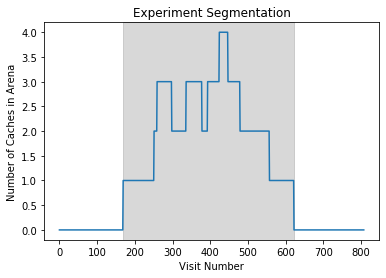

/home/chingf/engram/Emily/NeuralData/Gcamp/ForChing/ExtractedWithXY_Cleaned184430_09102019.mat
Too many runs
/home/chingf/engram/Emily/NeuralData/Gcamp/ForChing/ExtractedWithXY_Cleaned144233_09112019.mat


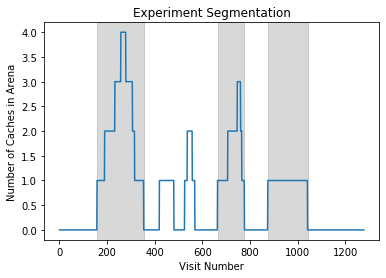

/home/chingf/engram/Emily/NeuralData/Gcamp/ForChing/ExtractedWithXY_Cleaned184526_09102019.mat


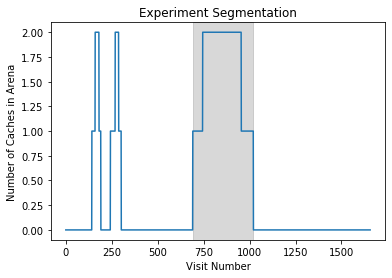

/home/chingf/engram/Emily/NeuralData/Gcamp/ForChing/ExtractedWithXY_Cleaned184946_09102019.mat
Too many runs
/home/chingf/engram/Emily/NeuralData/Gcamp/LMN73/20200930/2020-09-30-11-00-47_video_SplitIntoBatches_29_250_10_200/Results/ExtractedWithDLCAndAnnotations164614_10222020.mat


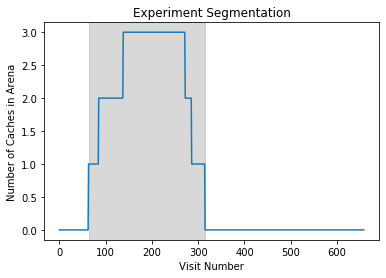

/home/chingf/engram/Emily/NeuralData/Gcamp/LMN73/20201009/2020-10-09-11-40-59_video_SplitIntoBatches_29_250_10_200/Results/ExtractedWithDLCAndAnnotations140712_10202020.mat
Too little runs
/home/chingf/engram/Emily/NeuralData/Gcamp/LMN73/20201012/2020-10-12-11-43-36_video_SplitIntoBatches_29_250_10_200/Results/ExtractedWithDLCAndAnnotations161757_10232020.mat


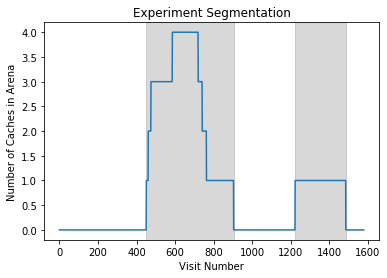

/home/chingf/engram/Emily/NeuralData/Gcamp/LMN73/20200918/2020-09-18-11-50-00_video_SplitIntoBatches_29_250_10_200/Results/ExtractedWithDLCAndAnnotations153159_10222020.mat
Too many runs
/home/chingf/engram/Emily/NeuralData/Gcamp/LMN73/20200908/2020-09-08-12-02-54_video_SplitIntoBatches_29_250_10_200/Results/ExtractedWithDLCAndAnnotations154721_10142020.mat
Too many runs
/home/chingf/engram/Emily/NeuralData/Gcamp/LMN73/20200910/2020-09-10-12-00-48_video_SplitIntoBatches_29_250_10_200/Results/ExtractedWithDLCAndAnnotations161306_10142020.mat
Too many runs
/home/chingf/engram/Emily/NeuralData/Gcamp/LMN73/20201007/2020-10-07-11-48-53_video_SplitIntoBatches_29_250_10_200/Results/ExtractedWithDLCAndAnnotations113100_10162020.mat


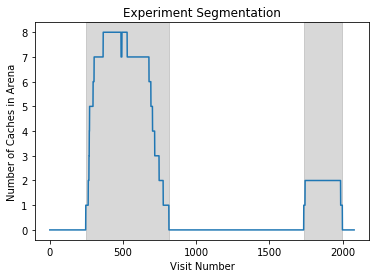

/home/chingf/engram/Emily/NeuralData/Gcamp/LMN73/20201005/2020-10-05-11-52-31_video_SplitIntoBatches_29_250_10_200/Results/ExtractedWithDLCAndAnnotations181955_10222020.mat


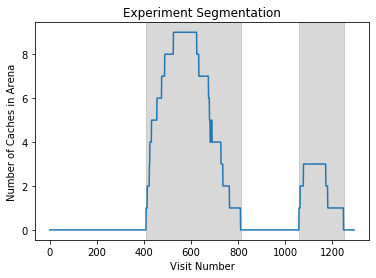

/home/chingf/engram/Emily/NeuralData/Gcamp/LMN73/20201002/2020-10-02-11-08-30_video_SplitIntoBatches_29_250_10_200/Results/ExtractedWithDLCAndAnnotations171921_10232020.mat


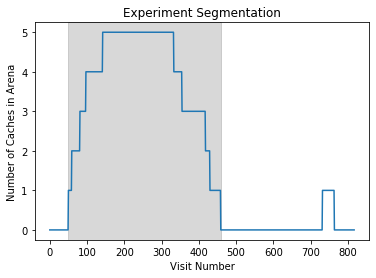

/home/chingf/engram/Emily/NeuralData/Gcamp/LMN73/20201016/2020-10-16-11-38-50_video_SplitIntoBatches_29_250_10_200/Results/ExtractedWithDLCAndAnnotations172910_10262020.mat
Too little runs
/home/chingf/engram/Emily/NeuralData/Gcamp/LMN73/20201014/2020-10-14-11-25-20_video_SplitIntoBatches_29_250_10_200/Results/ExtractedWithDLCAndAnnotations164321_10232020.mat
Too little runs
/home/chingf/engram/Emily/NeuralData/Gcamp/LMN73/20200922/2020-09-22-10-58-51_video_SplitIntoBatches_29_250_10_200/Results/ExtractedWithDLCAndAnnotations160204_10222020.mat


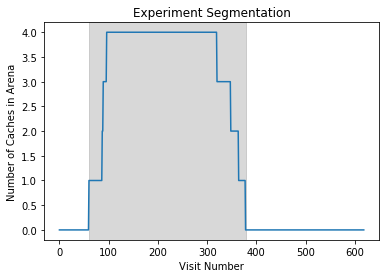

In [5]:
run_min_thresh = 100 # in hops
run_total_min_thresh = 0.25# in proportion
run_total_max_thresh = 0.6# in proportion
for key in h5_path_dict.keys():
    for fil in range(len(h5_path_dict[key])):
        fil_string = h5_path_dict[key][fil].as_posix()
        print(fil_string)
        f = h5py.File(fil_string, 'r')
        exp_data = ExpData(f)
        cache_presence = np.sum(exp_data.cache_present, axis=1)
        run_starts, run_lengths = find_runs(cache_presence)
        if np.sum(run_lengths) > run_total_max_thresh*exp_data.hop_wedges.size:
            print("Too many runs")
            continue
        elif np.sum(run_lengths) < run_total_min_thresh*exp_data.hop_wedges.size:
            print("Too little runs")
            continue
        else:
            good_starts = run_starts[run_lengths > run_min_thresh]
            if good_starts.size == 0:
                print("Too short runs")
                continue
            good_ends = good_starts + run_lengths[run_lengths > run_min_thresh]
            plt.plot(cache_presence)
            for s, e in zip(good_starts, good_ends):
                plt.axvspan(s, e, color="gray", alpha=0.3)
            plt.xlabel("Hop Number")
            plt.ylabel("Number of Caches in Arena")
            plt.title("Experiment Segmentation")
        plt.show()

In [4]:
def segment_exp(run_lengths, total_hops):
    run_min_thresh = 100 # in hops
    run_total_min_thresh = 0.25# in proportion
    run_total_max_thresh = 0.6# in proportion
    if np.sum(run_lengths) > run_total_max_thresh*total_hops:
        return False, None
    if np.sum(run_lengths) < run_total_min_thresh*total_hops:
        return False, None
    if (run_lengths > run_min_thresh).size == 0:
        return False, None
    hop_segmentation = np.zeros(total_hops)
    valid_runs = run_lengths > run_min_thresh
    cache_presence_start = run_starts[valid_runs]
    cache_presence_end = cache_presence_start + run_lengths[valid_runs]
    for start, end in zip(cache_presence_start, cache_presence_end):
        hop_segmentation[start:end] = 1
    return True, hop_segmentation

def get_place_calc_dict(place_calc, exp_data, exclude_frames):
    place_dict = {}
    spatial_info, significance_1d, bool_mask = place_calc.calc_place_cells(exp_data, exclude_frames)
    place_dict['spatial_info'] = spatial_info
    place_dict['significance'] = significance_1d
    place_dict['mean_frs'] = np.zeros((exp_data.num_neurs, 16))
    place_dict['tuning'] = np.zeros((exp_data.num_neurs, 16)).astype(bool)
    for neur in range(exp_data.num_neurs):
        if not significance_1d[neur]: continue
        frs = []
        for wedge in (np.arange(16) + 1):
            condn = np.logical_and(exp_data.wedges == wedge, bool_mask)
            wedge_frs = exp_data.fr[neur, condn]
            frs.append(wedge_frs)
        mean_fr = [np.nanmean(f) for f in frs]
        neur_tuning = np.argwhere(
            mean_fr > np.mean(mean_fr) + np.std(mean_fr)
            ).flatten()
        place_dict['mean_frs'][neur, :] = mean_fr
        place_dict['tuning'][neur, neur_tuning] = True
    return place_dict

/home/chingf/engram/Emily/NeuralData/Gcamp/LMN73/20200930/2020-09-30-11-00-47_video_SplitIntoBatches_29_250_10_200/Results/ExtractedWithDLCAndAnnotations164614_10222020.mat


/home/chingf/Code/cache-arena-analysis/analysis/tuning_measures/mutual_info.py:20: RuntimeWarning: invalid value encountered in true_divide
  log_term = np.log2(condn_mean_fr/mean_fr)
/home/chingf/Code/cache-arena-analysis/analysis/tuning_measures/mutual_info.py:20: RuntimeWarning: divide by zero encountered in log2
  log_term = np.log2(condn_mean_fr/mean_fr)
/home/chingf/Code/cache-arena-analysis/analysis/PlaceCalc.py:34: RuntimeWarning: invalid value encountered in true_divide
  spatial_info /= shuffled_spatial_info


[[ 3]
 [ 5]
 [20]
 [24]] vs [[ 5]
 [ 8]
 [15]
 [24]], with overlap of 2


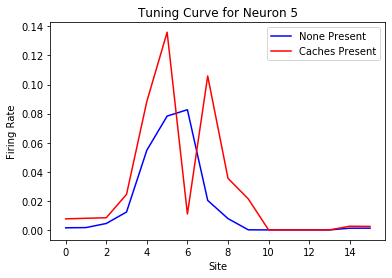

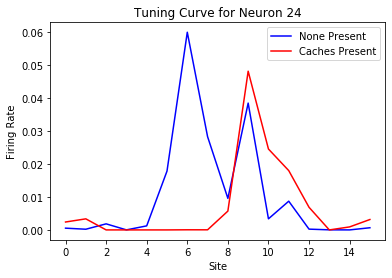

/home/chingf/engram/Emily/NeuralData/Gcamp/LMN73/20201009/2020-10-09-11-40-59_video_SplitIntoBatches_29_250_10_200/Results/ExtractedWithDLCAndAnnotations140712_10202020.mat
/home/chingf/engram/Emily/NeuralData/Gcamp/LMN73/20201012/2020-10-12-11-43-36_video_SplitIntoBatches_29_250_10_200/Results/ExtractedWithDLCAndAnnotations161757_10232020.mat


/home/chingf/Code/cache-arena-analysis/analysis/tuning_measures/mutual_info.py:20: RuntimeWarning: invalid value encountered in true_divide
  log_term = np.log2(condn_mean_fr/mean_fr)
/home/chingf/Code/cache-arena-analysis/analysis/tuning_measures/mutual_info.py:20: RuntimeWarning: divide by zero encountered in log2
  log_term = np.log2(condn_mean_fr/mean_fr)
/home/chingf/Code/cache-arena-analysis/analysis/PlaceCalc.py:34: RuntimeWarning: invalid value encountered in true_divide
  spatial_info /= shuffled_spatial_info


[[ 0]
 [ 1]
 [ 5]
 [ 7]
 [11]
 [12]
 [20]] vs [[ 0]
 [ 5]
 [ 7]
 [11]
 [20]], with overlap of 5


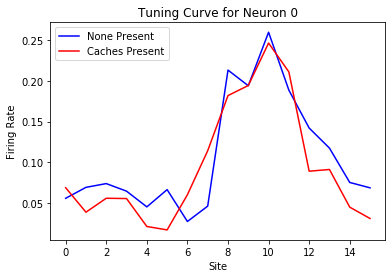

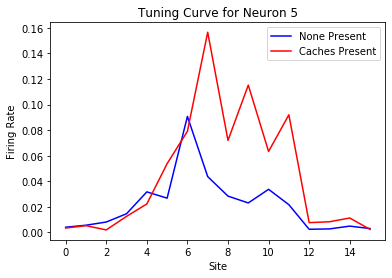

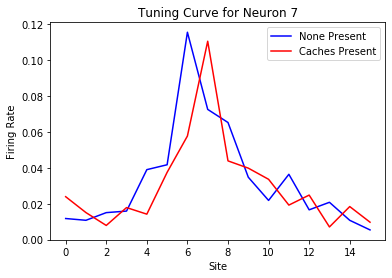

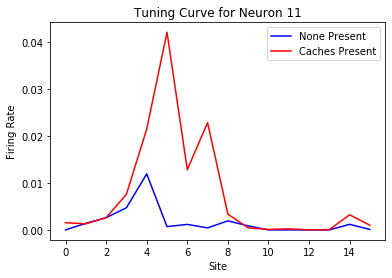

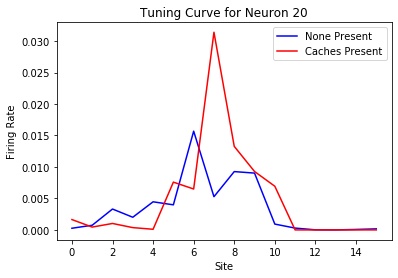

/home/chingf/engram/Emily/NeuralData/Gcamp/LMN73/20200918/2020-09-18-11-50-00_video_SplitIntoBatches_29_250_10_200/Results/ExtractedWithDLCAndAnnotations153159_10222020.mat
/home/chingf/engram/Emily/NeuralData/Gcamp/LMN73/20200908/2020-09-08-12-02-54_video_SplitIntoBatches_29_250_10_200/Results/ExtractedWithDLCAndAnnotations154721_10142020.mat
/home/chingf/engram/Emily/NeuralData/Gcamp/LMN73/20200910/2020-09-10-12-00-48_video_SplitIntoBatches_29_250_10_200/Results/ExtractedWithDLCAndAnnotations161306_10142020.mat
/home/chingf/engram/Emily/NeuralData/Gcamp/LMN73/20201007/2020-10-07-11-48-53_video_SplitIntoBatches_29_250_10_200/Results/ExtractedWithDLCAndAnnotations113100_10162020.mat


/home/chingf/Code/cache-arena-analysis/analysis/tuning_measures/mutual_info.py:20: RuntimeWarning: divide by zero encountered in log2
  log_term = np.log2(condn_mean_fr/mean_fr)
/home/chingf/Code/cache-arena-analysis/analysis/tuning_measures/mutual_info.py:20: RuntimeWarning: invalid value encountered in true_divide
  log_term = np.log2(condn_mean_fr/mean_fr)


[[ 6]
 [13]
 [27]] vs [[ 6]
 [ 7]
 [18]
 [22]
 [27]], with overlap of 2


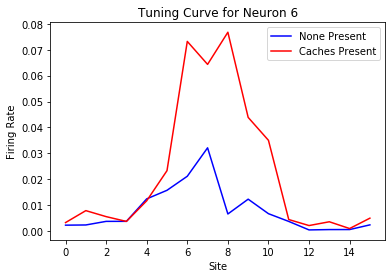

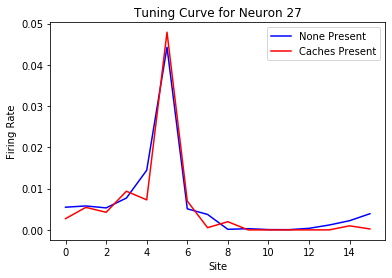

/home/chingf/engram/Emily/NeuralData/Gcamp/LMN73/20201005/2020-10-05-11-52-31_video_SplitIntoBatches_29_250_10_200/Results/ExtractedWithDLCAndAnnotations181955_10222020.mat


/home/chingf/Code/cache-arena-analysis/analysis/tuning_measures/mutual_info.py:20: RuntimeWarning: divide by zero encountered in log2
  log_term = np.log2(condn_mean_fr/mean_fr)
/home/chingf/Code/cache-arena-analysis/analysis/tuning_measures/mutual_info.py:20: RuntimeWarning: invalid value encountered in true_divide
  log_term = np.log2(condn_mean_fr/mean_fr)


[[ 0]
 [ 3]
 [ 5]
 [ 6]
 [ 7]
 [16]
 [22]
 [24]
 [28]
 [35]
 [38]] vs [[ 3]
 [ 5]
 [ 7]
 [24]
 [25]
 [28]
 [39]], with overlap of 5


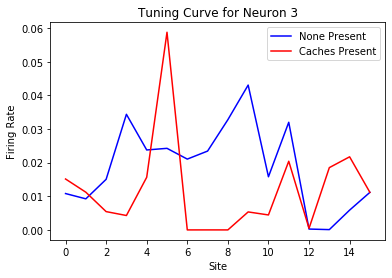

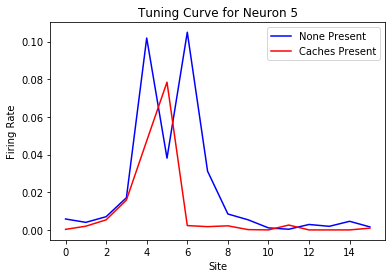

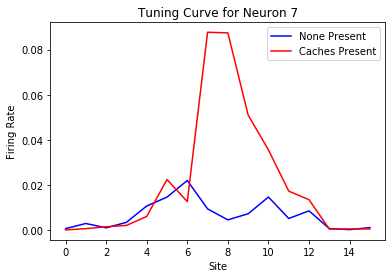

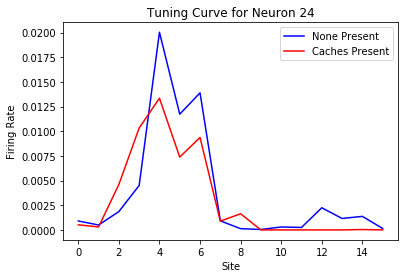

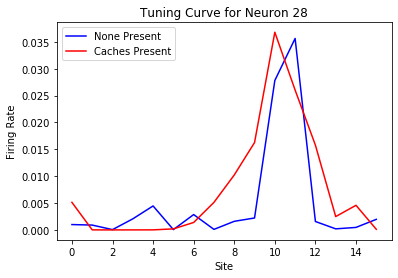

/home/chingf/engram/Emily/NeuralData/Gcamp/LMN73/20201002/2020-10-02-11-08-30_video_SplitIntoBatches_29_250_10_200/Results/ExtractedWithDLCAndAnnotations171921_10232020.mat


/home/chingf/Code/cache-arena-analysis/analysis/tuning_measures/mutual_info.py:20: RuntimeWarning: invalid value encountered in true_divide
  log_term = np.log2(condn_mean_fr/mean_fr)
/home/chingf/Code/cache-arena-analysis/analysis/tuning_measures/mutual_info.py:20: RuntimeWarning: divide by zero encountered in log2
  log_term = np.log2(condn_mean_fr/mean_fr)
/home/chingf/Code/cache-arena-analysis/analysis/PlaceCalc.py:34: RuntimeWarning: invalid value encountered in true_divide
  spatial_info /= shuffled_spatial_info


In [ ]:
data = {}
place_calc = PlaceCalc(
    num_shuffles=200, threshold=0.99, dimension=1, bins_2d=None
    )
for key in h5_path_dict.keys():
    for fil in range(len(h5_path_dict[key])):
        fil_string = h5_path_dict[key][fil].as_posix()
        if "LMN" not in fil_string: continue
        print(fil_string)
        f = h5py.File(fil_string, 'r')
        exp_data = ExpData(f)
        cache_presence = np.sum(exp_data.cache_present, axis=1)
        run_starts, run_lengths = find_runs(cache_presence)
        exp_is_valid, exp_segmentation = segment_exp(
            run_lengths, exp_data.hop_wedges.size
            )
        if not exp_is_valid:
            continue
        frame_segmentation = np.zeros(exp_data.num_frames)
        for hop, segment in enumerate(exp_segmentation):
            if segment == 0: continue
            frame_start = exp_data.hops[hop]
            frame_end = exp_data.hop_ends[hop]
            frame_segmentation[frame_start:frame_end] = 1
        data[fil_string] = {}
        data[fil_string]["NoCaches"] = get_place_calc_dict(
            place_calc, exp_data, frame_segmentation == 0
            )
        data[fil_string]["YesCaches"] = get_place_calc_dict(
            place_calc, exp_data, frame_segmentation == 1
            )
        nocache = data[fil_string]["NoCaches"]
        yescache = data[fil_string]["YesCaches"]
        nocache_sig = np.argwhere(nocache['significance'])
        yescache_sig = np.argwhere(yescache['significance'])
        union_sig = np.isin(nocache_sig, yescache_sig)
        print(f"{nocache_sig} vs {yescache_sig}, with overlap of {np.sum(union_sig)}")
        for neur in nocache_sig[union_sig]:
            plt.figure()
            plt.plot(nocache["mean_frs"][neur], color="blue", label="None Present")
            plt.plot(yescache["mean_frs"][neur], color="red", label="Caches Present")
            plt.title(f"Tuning Curve for Neuron {neur}")
            plt.xlabel("Site")
            plt.ylabel("Firing Rate")
            plt.legend()
            plt.show()
        
with open(pickle_dir / 'place_cells_segmented_1d.p', 'wb') as f: 
    pickle.dump(data, f)